In [ ]:
# Uncomment the next lines if running in Google Colab
# !pip install clinicadl==0.1.2
# !/bin/bash -c "$(curl -k https://aramislab.paris.inria.fr/files/software/scripts/install_conda_ants.sh)"
# from os import environ
# environ['ANTSPATH']="/usr/local/bin"

# Prepare your neuroimaging data

Different steps to perform before training your model or performing classification. In this notebook, we will see how to:

1. **Organize** your neuroimaging data.
2. **Preprocess** of your neuroimaging data.
3. Check the preprocessing **quality check**.
4. **Extract tensors** from your preprocessed data.



## Organization of neuroimaging data: the Brain Imaging Data Structure (BIDS)

Before processing your neuroimaging data, several steps may be needed. These steps can include converting the images to a format readable by neuroimaging software tools (e.g. converting to NIfTI) and organizing your files in a specific way. Several tools will require that your clinical and imaging data follow the **Brain Imaging Data Structure (BIDS)** [(Gorgolewski et al., 2016)](https://doi.org/10.1038/sdata.2016.44). The BIDS standard is based on a file hierarchy rather than on a database management system, thus facilitating its deployment. Thanks to its clear and simple way to describe neuroimaging and behavioral data, it has been easily adopted by the neuroimaging community. Organizing a dataset following the BIDS hierarchy simplifies the execution of neuroimaging software tools. 

Here is a general overview of the BIDS structure. If you need more details, please check the [documentation](https://bids-specification.readthedocs.io/en/latest/) on the [website](http://bids.neuroimaging.io/).

<pre>
BIDS_Dataset/
├── participants.tsv
├── sub-CLNC01/
│   │   ├── ses-M00/
│   │   │   └── anat/
│   │   │       └── <b>sub-CLNC01_ses-M00_T1w.nii.gz</b>
│   │   └── sub-CLNC01_sessions.tsv
├── sub-CLNC02/
│   │   ├── ses-M00/
│   │   │   └── anat/
│   │   │       └── <b>sub-CLNC02_ses-M00_T1w.nii.gz</b>
│   │   └── sub-CLNC02_sessions.tsv
└──  ...
</pre>


The OASIS dataset contains imaging data in ANALYZE format and does not provide a BIDS version of the data. To solve this issue, [Clinica provides a converter](http://www.clinica.run/doc/Converters/OASIS2BIDS/) to automatically convert ANALYZE files into NIfTI following the BIDS standard.

A command line instruction is enough to get the data in BIDS format:

```bash
clinica convert oasis-to-bids <dataset_directory> <clinical_data_directory> <bids_directory>
```

where:

  - `dataset_directory` is the path to the original OASIS images' directory;
  - `clinical_data_directory` is the path to the directory containing the `oasis_cross-sectional.csv` file;
  - `bids_directory` is the path to the output directory, where the BIDS-converted version of OASIS will be stored.


In [ ]:
# Download the example dataset of 4 images
!curl -k https://aramislab.paris.inria.fr/files/data/databases/tuto/OasisDatabase.tar.gz -o OasisDatabase.tar.gz
!tar xf OasisDatabase.tar.gz

In [ ]:
# Convert the example dataset to BIDS
!clinica convert oasis-to-bids OasisDatabase/RawData OasisDatabase/ClinicalData OasisBids_example

## Image preprocessing with the `t1-linear` pipeline

Although convolutional neural networks (CNNs) have the potential to extract low-to-high level features from raw images, a proper image preprocessing procedure is fundamental to ensure a good classification performance (in particular for Alzheimer's disease (AD) classification where datasets are relatively small).

In the context of deep learning-based classification, image preprocessing procedures often include:

- **Bias field correction:** MR images can be corrupted by a low frequency and smooth signal caused by magnetic field inhomogeneities. This bias field induces variations in the intensity of the same tissue in different locations of the image, which deteriorates the performance of image analysis algorithms such as registration.

- **Image registration:** Medical image registration consists of spatially aligning two or more images, either globally (rigid and affine registration) or locally (non-rigid registration), so that voxels in corresponding positions contain comparable information.

Finally, a **Cropping** of the registered images can be performed to remove the background and to reduce the computing power required when training deep learning models.

For this tutorial, we propose a "minimal preprocessing" (as described in [(Wen et al., 2020)](https://doi.org/10.1016/j.media.2020.101694)) implemented in the [`t1-linear` pipeline](http://www.clinica.run/doc/Pipelines/T1_Linear/) using the [ANTs](http://stnava.github.io/ANTs/) software package [(Avants et al., 2014)](https://doi.org/10.3389/fninf.2014.00044). This preprocessing includes:

- **Bias field correction** using the N4ITK method [(Tustison et al., 2010)](https://doi.org/10.1109/TMI.2010.2046908).

- **Affine registration** to the MNI152NLin2009cSym template (Fonov et al., [2011](https://doi.org/10.1016/j.neuroimage.2010.07.033), [2009](https://doi.org/10.1016/S1053-8119(09)70884-5) ) in MNI space with the SyN algorithm [(Avants et al., 2008)](https://doi.org/10.1016/j.media.2007.06.004).

- **Cropping** resulting in final images of size 169×208×179 with 1 mm3 isotropic voxels.


These steps can be run with this simple command line:
```Text
clinica run t1-linear <bids_directory> <caps_directory>
```
where:

- `bids_directory` is the input folder containing the dataset in a [BIDS](http://www.clinica.run/doc/BIDS/) hierarchy,
- `caps_directory` is the output folder containing the results in a [CAPS](http://www.clinica.run/doc/CAPS/) hierarchy.


```{warning}
The following command can take some time to execute, depending on the configuration of your host machine. Running in a classical **Colab** instance can take up to 30 min.

We will increase a little bit the computation capacity using 2 cores with the `--n_procs 2` flag. Since there are 4 images, you can set `--n_procs 4` if your computer can handle this.
```

In [ ]:
!clinica run t1-linear ./OasisBids_example ./OasisCaps_example --n_procs 2

Once the pipeline has been run, the necessary outputs for the next steps are saved using a specific suffix: 
    `_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.nii.gz`. 

```{warning}
The registration algorithm provided by ANTs exposes some reproducibility issues when running in different environments. The outputs are "visually" very close but not exactly the same. For further information and some clues on how to reduce the variability please read this [page](https://github.com/ANTsX/ANTs/wiki/antsRegistration-reproducibility-issues).
```

For example, processed images from our dataset are:

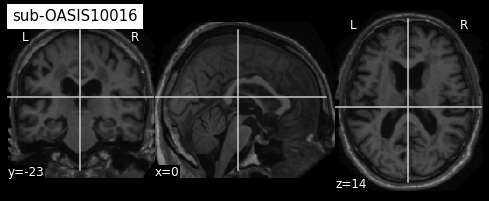

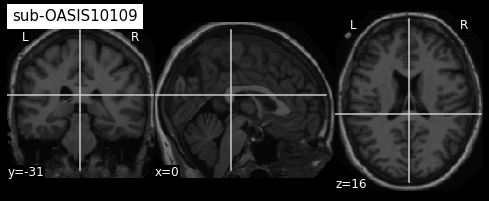

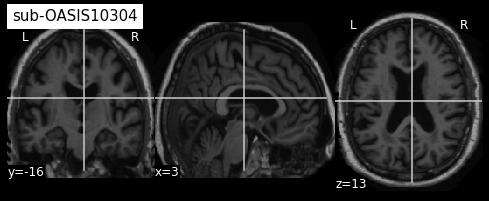

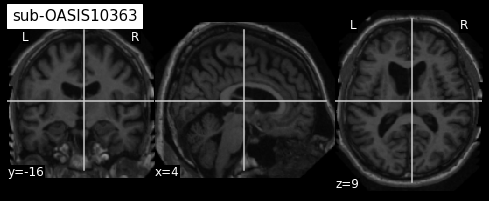

In [1]:
from nilearn import plotting

suffix = '_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.nii.gz'

sub1 = 'OasisCaps_example/subjects/sub-OASIS10016/ses-M00/t1_linear/sub-OASIS10016_ses-M00' + suffix 
sub2 = 'OasisCaps_example/subjects/sub-OASIS10109/ses-M00/t1_linear/sub-OASIS10109_ses-M00' + suffix
sub3 = 'OasisCaps_example/subjects/sub-OASIS10304/ses-M00/t1_linear/sub-OASIS10304_ses-M00' + suffix
sub4 = 'OasisCaps_example/subjects/sub-OASIS10363/ses-M00/t1_linear/sub-OASIS10363_ses-M00' + suffix

plotting.plot_anat(sub1, title="sub-OASIS10016")
plotting.plot_anat(sub2, title="sub-OASIS10109")
plotting.plot_anat(sub3, title="sub-OASIS10304")
plotting.plot_anat(sub4, title="sub-OASIS10363")

From the visualization above, we can see that the last two images have some missing skin voxels on top of the brain i.e. these images are slightly cropped. Besides, we did not compare them to the [MNI152NLin2009cSym template](https://bids-specification.readthedocs.io/en/stable/99-appendices/08-coordinate-systems.html) to evaluate the quality of the registration.

OASIS-1 dataset contains 416 images so quality check of the whole dataset can be very time consuming. The next section gives you some ideas on how to keep only images correctly preprocessed, when running in a large dataset.

## Quality check of your preprocessed data

To automatically assess the quality of the preprocessing, we propose to use a pretrained network which learnt to classify images that are adequately registered to a template from others for which the registration failed. This procedure is adaptated from [(Fonov et al, 2018)](https://www.biorxiv.org/content/10.1101/303487v1), using their pretrained models. The original code of [(Fonov et al, 2018)](https://www.biorxiv.org/content/10.1101/303487v1) can be found on [GitHub](https://github.com/vfonov/deep-qc).

The quality check can be run with the following command line:
```
clinicadl quality-check <preprocessing> <caps_directory> <output_path>
```
where:

- `preprocessing` corresponds to the preprocessing pipeline whose outputs will be checked (`t1-linear`),
- `caps_directory` is the folder containing the results of the `t1-linear` pipeline in a [CAPS](http://www.clinica.run/doc/CAPS/Introduction/) hierarchy,
- `output_path` is the path to the output TSV file containing QC results.

In [ ]:
!clinicadl preprocessing quality-check t1-linear OasisCaps_example QC_result.tsv -cpu

After execution of the quality check procedure, the `QC_result.tsv` file will look like this:

| participant_id | session_id | pass_probability   | pass  |
|----------------| -----------|--------------------|-------|
| sub-OASIS10016 | ses-M00    | 0.9936990737915039 | True  |
| sub-OASIS10109 | ses-M00    | 0.9772214889526367 | True  |
| sub-OASIS10363 | ses-M00    | 0.7292165160179138 | True  |
| sub-OASIS10304 | ses-M00    | 0.1549495905637741 | <font color="red">False</font> |

Based on this TSV file, participant `OASIS10304` should be discarded for the rest of your anlysis. If you compare its registration with [MNI152NLin2009cSym template](https://bids-specification.readthedocs.io/en/stable/99-appendices/08-coordinate-systems.html), you will see that temporal regions are misaligned as well as occipital regions and cerebellum leading to this low probabilty value. ;-)


##  Tensor extraction with the `deeplearning-prepare-data` pipeline

Once the dataset has been preprocessed, we need to obtain files suited for the training phase.
This task can be performed using the [Clinica `deeplearning-prepare-data` pipeline](http://www.clinica.run/doc/Pipelines/DeepLearning_PrepareData/).

This pipeline prepares images generated by Clinica to be used with the PyTorch deep learning library [(Paszke et al., 2019)](https://papers.nips.cc/paper/9015-pytorch-an-imperative-style-high-performance-deep-learning-library). Three types of tensors are proposed: 3D images, 3D patches or 2D slices.

This pipeline selects the preprocessed images, extract the "tensors", and write them as output files for the entire images, for each slice or for each patch.

You simply need to type the following command line:

```bash
clinica run deeplearning-prepare-data <caps_directory> <tensor_format>
```
where:

- `caps_directory` is the folder containing the results of the [`t1-linear` pipeline](#Preprocess-raw-images-with-t1-linear-pipeline) and the output of the present command, both in a CAPS hierarchy.
- `tensor_format` is the format of the extracted tensors. You can choose between `image` to convert to PyTorch tensor the whole 3D image, `patch` to extract 3D patches and `slice` to extract 2D slices from the image.

Output files are stored into a new folder (inside the CAPS) and follows a struture like this:

```text
deeplearning_prepare_data
├── image_based
│   └── t1_linear
│       └── sub-<participant_label>_ses-<session_label>_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt
├── patch_based
│   └── t1_linear
│       ├── sub-<participant_label>_ses-<session_label>_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_patchsize-50_stride-50_patch-0_T1w.pt
│       ├── sub-<participant_label>_ses-<session_label>_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_patchsize-50_stride-50_patch-1_T1w.pt
│       ├── ...
│       └── sub-<participant_label>_ses-<session_label>_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_patchsize-50_stride-50_patch-N_T1w.pt
└── slice_based
    └── t1_linear
        ├── sub-<participant_label>_ses-<session_label>_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_axis-axi_channel-rgb_slice-0_T1w.pt
        ├── sub-<participant_label>_ses-<session_label>_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_axis-axi_channel-rgb_slice-1_T1w.pt
        ├── ...
        ├── sub-<participant_label>_ses-<session_label>_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_axis-axi_channel-rgb_slice-N_T1w.pt
```

In short, there is a folder for each feature (**image, slice or patch**) and inside the numbered tensor files with the corresponding feature. 

<div class="alert alert-info">

**Note:** You can choose to only extract the tensors for the whole images (`clinica run deeplearning-prepare-data <caps_directory> image` ) and continue working with one single file per subject/session. 
    
The package `clinicadl` is able to extract patches or slices _on-the-fly_ (from one single file) when running training or inference tasks. The downside of this approach is that, depending on the size of your dataset, you have to make sure that you have enough memory ressources in your GPU card to host the full images/tensors for all your data. 

If the memory size of the GPU card you use is too small, we suggest you to extract the patches and/or the slices using the proper `tensor_format` option of the command described above.
</div>

(If you failed to obtain the preprocessing using the `t1-linear` pipeline, please uncomment the next cell)

In [ ]:
# !curl -k https://aramislab.paris.inria.fr/files/data/databases/tuto/OasisCaps1.tar.gz -o OasisCaps1.tar.gz
# !tar xf OasisCaps1.tar.gz

To perform the feature extraction for our dataset, run the following cell: 

In [ ]:
!clinica run deeplearning-prepare-data ./OasisCaps_example image

At the end of this command, a new directory named `deeplearning_prepare_data` is created inside each subject/session of the CAPS structure. We can easily verify:

In [ ]:
!tree -L 3 ./OasisCaps_example/subjects/sub-OASIS10*/ses-M00/deeplearning_prepare_data/